# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [2]:
!nvidia-smi

Wed May 12 08:34:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p /content/drive/MyDrive/ML2021-hw6/

# You may replace the workspace directory if you want.
# workspace_dir = '/content/drive/MyDrive/ML2021-hw6'
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm
# Stylegan2
!pip install stylegan2_pytorch

     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 276kB 45.2MB/s 
     |████████████████████████████████| 163kB 57.2MB/s 
     |████████████████████████████████| 163kB 55.9MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 296kB 63.7MB/s 
     |████████████████████████████████| 153kB 61.1MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=9e27524c752c062ff227e5e726efdf010d211b3cc91f5409df8b2840af6cb029
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
  Created wheel for vector-quantize-pytorch: filename=vector_quantize_pytorch-0.1.0-cp37-none-any.whl size=2576 sha256=62f81503a78ca942

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [5]:
!gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"

Downloading...
From: https://drive.google.com/uc?id=1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p
To: /content/crypko_data.zip
452MB [00:10, 43.4MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [6]:
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## Random seed
Set the random seed to a certain value for reproducibility.

In [7]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1116)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [8]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [9]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


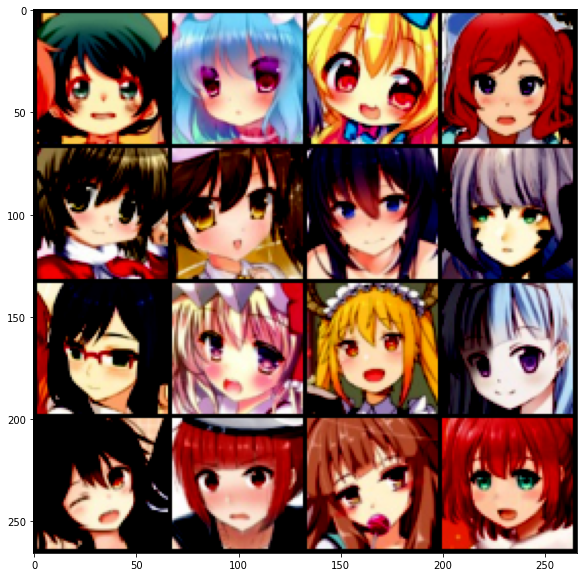

In [10]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

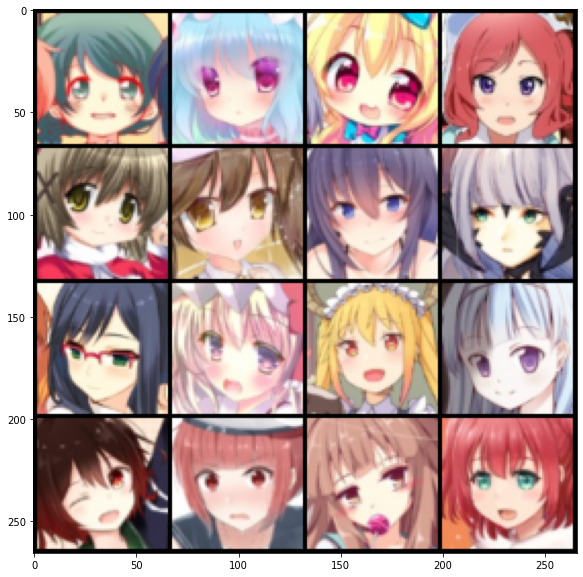

In [11]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Training

In [12]:
!export CUDA_VISIBLE_DEVICES=0

In [13]:
!stylegan2_pytorch --data ./faces --name stylegan2 --models_dir /content/drive/MyDrive/ML2021-hw6/models --results_dir /content/drive/MyDrive/ML2021-hw6/results --image-size 64 --num-train-steps 100000

stylegan2<./faces>:   0% 0/100000 [00:00<?, ?it/s]G: 502.04 | D: 7.12 | GP: 4.19
stylegan2<./faces>:   0% 33/100000 [00:20<17:27:52,  1.59it/s]G: 6.92 | D: 1.06 | GP: 42.86
stylegan2<./faces>:   0% 93/100000 [00:53<15:59:09,  1.74it/s]G: 3.88 | D: 3.56 | GP: 45.89
stylegan2<./faces>:   0% 149/100000 [01:24<15:45:20,  1.76it/s]G: 0.70 | D: 1.18 | GP: 2.08
stylegan2<./faces>:   0% 187/100000 [01:45<15:27:33,  1.79it/s]G: 2.40 | D: 2.19 | GP: 0.67
stylegan2<./faces>:   0% 243/100000 [02:17<15:29:06,  1.79it/s]G: 14.84 | D: 0.32 | GP: 0.02
stylegan2<./faces>:   0% 299/100000 [02:47<15:21:15,  1.80it/s]G: 2.49 | D: 0.91 | GP: 0.67
stylegan2<./faces>:   0% 337/100000 [03:09<15:37:01,  1.77it/s]G: 0.69 | D: 1.60 | GP: 0.70
stylegan2<./faces>:   0% 393/100000 [03:40<15:28:53,  1.79it/s]G: 5.87 | D: 1.33 | GP: 2.29
stylegan2<./faces>:   0% 448/100000 [04:11<15:18:48,  1.81it/s]G: 1.76 | D: 0.28 | GP: 0.64
stylegan2<./faces>:   0% 485/100000 [04:32<15:30:01,  1.78it/s]G: 3.04 | D: 0.02 | GP: 1.0

## Inference
Use the trained model to generate anime faces!

### Generate and show some images.


continuing from previous epoch - 100
loading from version 1.8.1


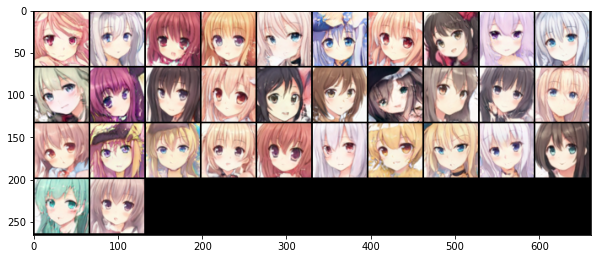

In [14]:
# Generate 1000 images and make a grid to save them.
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = '/content/drive/MyDrive/ML2021-hw6',   # path to where you invoked the command line tool
    name = 'stylegan2'                             # the project name, defaults to 'default'
)


n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.75)  # pass through mapping network

# Show 32 of the images.
imgs_sample = loader.styles_to_images(styles[:32])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [15]:
# Save the generated images.
os.makedirs('/content/drive/MyDrive/ML2021-hw6/output/', exist_ok=True)
eval_batch_size = 100

for i in range(10):
    images = loader.styles_to_images(styles[i*eval_batch_size:(i+1)*eval_batch_size])
    for j in range(eval_batch_size):
        save_image(images[j], f'/content/drive/MyDrive/ML2021-hw6/output/{i*eval_batch_size+j+1}.jpg') # save your images, or do whatever you desire

# Compress the images.
%cd /content/drive/MyDrive/ML2021-hw6/output
!tar -zcf ../images.tgz *.jpg
%cd ..

/content/drive/MyDrive/ML2021-hw6/output
/content/drive/MyDrive/ML2021-hw6


# References

1. I modify the sample code from TA of machine learning course at NTU
2. StyleGAN2 is from https://github.com/lucidrains/stylegan2-pytorch
